<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/button-redesign-tests/button_redesign_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проверка гипотез в связи с редизайном кнопки на главной странице сервиса подписки аналитику в соц. сетях

## Описание кейса

- **Продукт**: SaaS, подписка, аналитика в соц. сетях. Пользователь может отслеживать свою активность и активность своих друзей, подписавшись в сервисе
- **Тестируемое изменение**: изменение h1 и подписи в кнопке на первом экране главной страницы. Цель – зацепить пользователя
- **Выборка**: в эксперименте участвовали все пользователи, посетившие главную страницу сервиса

## Описание данных

В датасете есть поля:

- `date` – дата;
- `deviceCategory` – тип устройства;
- `sourceMedium` – источник и канал привлечения;
- `experimentVariant` – группа (варианта) эксперимента, в которую был определен пользователь (контроль – `Check`, тест – `Find out in 30 seconds`);
- `clickButtonOnMain` – кликнул/не кликнул по кнопке на главной странице в рамках сеанса (1 – кликнул, или 0 – не кликнул);
- `sessionDuration` – Время проведенное на сайте в рамках сеанса.

В датасете есть информация о пользователях, которые приняли участие в эксперименте, но не кликнули на целевую кнопку.

## Задача

Проверить гипотезы:

- есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку;
- изменилось ли время проведенное на сайте в рамках сеанса.

## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import numpy as np
import pandas as pd

# исследовательский анализ данных
import seaborn as sns
import matplotlib.pyplot as plt

# статистическая проверка гипотез
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

## Загрузка данных

In [3]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/button-redesign-tests'

In [5]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw2_1.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

In [6]:
# вывод на экран первых пяти строк датасета
data.head()

,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,123.109765
2,2019-11-27,mobile,maz.com / referral,test,1,135.604001
3,2019-11-27,mobile,(direct) / (none),test,1,134.451017
4,2019-11-27,desktop,google / organic,test,1,130.691087
5,2019-11-27,mobile,google / organic,control,1,117.617311


In [7]:
# вывод на экран общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2943 entries, 1 to 2943
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2943 non-null   object 
 1   deviceCategory     2943 non-null   object 
 2   sourceMedium       2943 non-null   object 
 3   experimentVariant  2943 non-null   object 
 4   clickButtonOnMain  2943 non-null   int64  
 5   sessionDuration    2943 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 160.9+ KB


## EDA

In [8]:
# вывод на экран долей контрольной и тестовой выборок в датасете
data.experimentVariant.value_counts(normalize = True).to_frame()

,experimentVariant
control,0.504587
test,0.495413


Мы видим, что размеры контрольной и тестовой групп примерно одинаковые, т.е. по каждой группе нам доступно чуть меньше 1500 объектов.

### Доля кликов на целевую кнопку

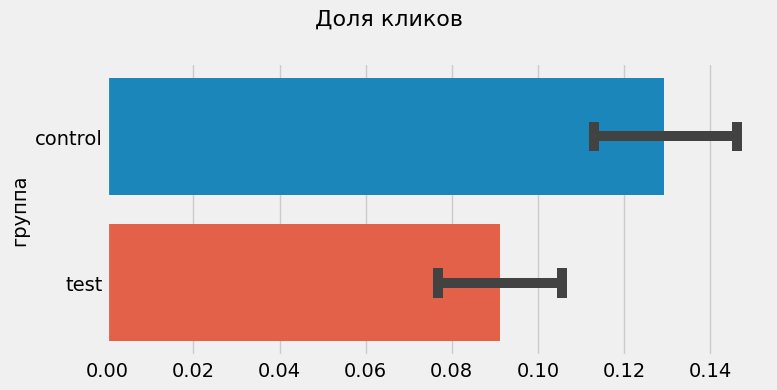

In [9]:
# вывод на экран столбачтого графика доли кликов на целевую кнопку в каждой из групп
fig = plt.figure(figsize = (8, 4))

sns.barplot(data    = data,
            x       = "clickButtonOnMain",
            y       = "experimentVariant",
            capsize = 0.2)

plt.xlabel('')
plt.ylabel('группа', fontsize = 14)

fig.suptitle('Доля кликов', fontsize = 16)

plt.tight_layout()
plt.show()

Мы видим, что:
- в обоих группах:
    - доля кликов относительно невысокая;
    - 95%-е доверительные интервалы примерно равны и не пересекаются;
- в тестовой группе доля кликов ниже (9% против 13%).

### Время проведенное на сайте в рамках сеанса

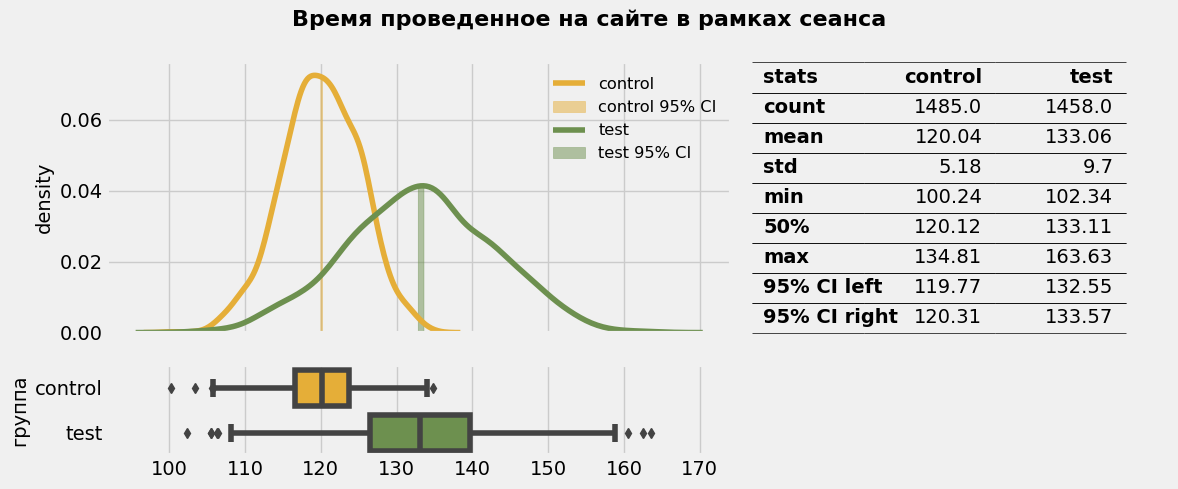

In [10]:
# вывод на экран статистики и графиков распределения времени,
# проведенного на сайте в рамках сеанса (для каждой из групп)
palette = ['#e5ae38', '#6d904f']

fig, ax = plt.subplots(nrows         = 2,
                       ncols         = 2,
                       figsize       = (12, 5),
                       height_ratios = (3, 1),
                       width_ratios  = (6, 4),
                       sharex        = 'col')

ax = ax.flatten()

cis_left = []
cis_right = []

for group, color in zip(data.experimentVariant.unique(), palette):
    group_data = data[data.experimentVariant == group]
    group_mean = np.mean(group_data.sessionDuration)
    group_std  = np.std(group_data.sessionDuration, ddof = 1)
    group_se   = group_std / np.sqrt(len(group_data))

    g = sns.kdeplot(data        = group_data,
                    x           = 'sessionDuration',
                    common_norm = False,
                    color       = color,
                    ax          = ax[0])

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    ci_left = group_mean - group_se * 2
    ci_right = group_mean + group_se * 2

    cis_left.append(np.round(ci_left, 2))
    cis_right.append(np.round(ci_right, 2))

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci_left) & (x < ci_right),
                   color = color,
                   alpha = 0.5,
                   label = f'{group} 95% CI')

ax[0].legend(labels = ['control', 'control 95% CI', 'test', 'test 95% CI'],
             loc            = 'upper right',
             frameon        = False,
             fontsize       = 'small')

ax[0].set_ylabel('density', fontsize = 14)

feature_stats = data.groupby('experimentVariant').sessionDuration.describe().T.round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats'},
                     inplace = True)

feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

the_table = ax[1].table(cellText  = feature_stats.values,
                        colLabels = feature_stats.columns,
                        bbox      = (0, 0, 0.9, 1),
                        colWidths = [0.3, 0.35, 0.35],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

sns.boxplot(data       = data,
            x          = 'sessionDuration',
            y          = 'experimentVariant',
            palette    = palette,
            saturation = 1,
            ax         = ax[2])

ax[2].set_xlabel('')
ax[2].set_ylabel('группа', fontsize = 14)

ax[3].axis('off')

fig.suptitle('Время проведенное на сайте в рамках сеанса',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

Мы видим, что:

- в обеих группах:
    - распределение значений признака `sessionDuration` похоже на нормальное распределение;
    - есть небольшое количество выбросов;
    - 95%-е доверительные интервалы достаточно маленькие (благодаря большому количеству объектов) и не пересекаются;

- в тестовой группе:
    - больше среднее значение метрики (133 против 120);
    - вдвое больше стандартное отклонение (9.7 против 5.2).

## Проверка гипотез

На данном этапе проверим две гипотезы:

1. Есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку?
2. Изменилось ли время проведенное на сайте в рамках сеанса?

Для проверки обеих гипотез установим уровень значимости 95% и соответствующее ему значение α = 0.05

In [11]:
# установление значения alpha
ALPHA = 0.05

### Есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку

В ходе EDA мы установили, что в тестовой группе ниже доля кликов на целевую кнопку.

Мы хотим сравнить доли кликов на целевую кнопку в двух группах и имеем дело с распределением Бернулли, а также имеем достаточно достаточно наблюдений (>30 на варианту), поэтому для проверки гипотезы используем двухпропорционный z-тест.

Сформулируем нулевую и альтернативную гипотезы:
- **нулевая гипотеза**: доли кликов на целевую кнопку в контрольной и тестовой группах равны;
- **альтернативная гипотеза**: доли кликов на целевую кнопку в контрольной и тестовой группах различаются.

In [12]:
# расчет количества объектов и кликов для каждой группы
clickButtonOnMain_agg = data.groupby('experimentVariant')['clickButtonOnMain'].agg(['sum', 'count']).T.values
count = clickButtonOnMain_agg[0,:]
nobs = clickButtonOnMain_agg[1,:]

In [13]:
# проведение z-теста пропорций
stat, pval = proportions_ztest(count, nobs)
print(f'p-value {np.round(pval, 3)} is less than alpha: {pval < ALPHA}')

p-value 0.001 is less than alpha: True


Полученный p-value (0.001) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве долей кликов на целевую кнопку в контрольной и тестовой группах в пользу альтернативной гипотезы об их различии (в тестовой группе ниже доля кликов).

### Изменилось ли время проведенное на сайте в рамках сеанса

В ходе EDA мы установили, что в тестовой группе больше среднее время, проведенное на сайте в рамках сеанса.

Мы предположительно имеем дело с нормальным распределением, хотим сравнить средние значения, а также имеем достаточно достаточно наблюдений (>30 на варианту), поэтому для проверки гипотезы используем двухсторонний t-тест.

Сформулируем нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: время, проведенное на сайте в рамках сеанса, в контрольной и тестовой группах равно;
- **альтернативная гипотеза**: время, проведенное на сайте в рамках сеанса, в контрольной и тестовой группах различается.

In [14]:
# сохранение в отдельные переменные времени, проведенного пользователями
# каждой группы на сайте в рамках сеанса
control_sessionDuration = data[data.experimentVariant == 'control'].sessionDuration
test_sessionDuration = data[data.experimentVariant == 'test'].sessionDuration

In [15]:
# проведение t-теста
stat, pval = stats.ttest_ind(control_sessionDuration, test_sessionDuration, equal_var = False)
print(f'p-value {np.round(pval, 3)} is less than alpha: {pval < ALPHA}')

p-value 0.0 is less than alpha: True


Полученный p-value (менее 0.001)  меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве времени, проведенного на сайте в рамках сеанса, в контрольной и тестовой группах, в пользу альтернативной гипотезы об его различии (в тестовой группе больше среднее время, проведенное на сайте в рамках сеанса).

## Общие выводы

В ходе работы над кейсом мы проанализировали результаты эксперимента по редизайну кнопки на главной странице сервиса подписки аналитику в соц. сетях и проверили две гипотезы:

- есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку;
- изменилось ли время проведенное на сайте в рамках сеанса.

**EDA**

*Доля кликов на целевую кнопку*

- в обоих группах:
    - доля кликов относительно невысокая;
    - 95%-е доверительные интервалы примерно равны и не пересекаются;
- в тестовой группе доля кликов ниже (9% против 13%).

*Время проведенное на сайте в рамках сеанса*

- в обеих группах:
    - распределение значений признака `sessionDuration` похоже на нормальное распределение;
    - есть небольшое количество выбросов;
    - 95%-е доверительные интервалы достаточно маленькие (благодаря большому количеству объектов) и не пересекаются;

- в тестовой группе:
    - больше среднее значение метрики (133 против 120);
    - вдвое больше стандартное отклонение (9.7 против 5.2).

**Проверка гипотез**

Для проверки обеих гипотез мы установили уровень значимости 95% и соответствующее ему значение α = 0.05

*Есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку*

В ходе EDA мы установили, что в тестовой группе ниже доля кликов на целевую кнопку.

Мы решили использовать двухпропорционный z-тест, поскольку:

- мы хотели сравнить доли кликов на целевую кнопку в двух группах;
- мы имеем дело с распределением Бернулли;
- мы имеем достаточно достаточно наблюдений (>30 на варианту).

Мы сформулировли нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: доли кликов на целевую кнопку в контрольной и тестовой группах равны;
- **альтернативная гипотеза**: доли кликов на целевую кнопку в контрольной и тестовой группах различаются.

Полученный p-value (0.001) меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы смогли отвергуть нулевую гипотезу о равенстве долей кликов на целевую кнопку в контрольной и тестовой группах в пользу альтернативной гипотезы об их различии (в тестовой группе ниже доля кликов).

*Изменилось ли время проведенное на сайте в рамках сеанса*

Мы решили использовать двухсторонний t-тест, поскольку:

- мы предположительно имеем дело с нормальным распределением;
- мы хотим сравнить средние значения;
- мы имеем достаточно достаточно наблюдений (>30 на варианту).

Мы сформулировли нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: время, проведенное на сайте в рамках сеанса, в контрольной и тестовой группах равно;
- **альтернативная гипотеза**: время, проведенное на сайте в рамках сеанса, в контрольной и тестовой группах различается.

Полученный p-value (менее 0.001)  меньше установленного значения α (0.05), поэтому на уровне значимости 95% мы смогли отвергуть нулевую гипотезу о равенстве времени, проведенного на сайте в рамках сеанса, в контрольной и тестовой группах, в пользу альтернативной гипотезы об его различии (в тестовой группе больше среднее время, проведенное на сайте в рамках сеанса).

В результате проведения тестов мы смогли отвергнуть обе нулевых гипотезы, поэтому мы можем считать результаты проведенного эксперимента успешными.